Este archivo es solo para seperar mi parte temporalmente y debuggearlo mejor, cuando este bien lo meto en el principal.

# LIBRERIAS

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# CARGA DE DATOS

In [70]:
import os

# Función para obtener rutas ordenadas por nombre de archivo
def get_sorted_paths(folder, extension="tiff"):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(extension)]
    )

# Rutas de las imágenes y las máscaras
img_paths = get_sorted_paths("roads/sat", extension="tiff")
mask_paths = get_sorted_paths("roads/gt", extension="tif")

# Verifica que el orden coincida
for img, mask in zip(img_paths, mask_paths):
    print(f"Imagen: {os.path.basename(img)}, Máscara: {os.path.basename(mask)}")

# Verificar si se encontraron archivos
if len(img_paths) == 0 or len(mask_paths) == 0:
    print("No se encontraron imágenes o máscaras. Verifica las rutas.")
else:
    print(f"Imágenes encontradas: {len(img_paths)} | Máscaras encontradas: {len(mask_paths)}")


Imagen: 10078675_15.tiff, Máscara: 10078675_15.tif
Imagen: 10228675_15.tiff, Máscara: 10228675_15.tif
Imagen: 10228705_15.tiff, Máscara: 10228705_15.tif
Imagen: 10228720_15.tiff, Máscara: 10228720_15.tif
Imagen: 10228735_15.tiff, Máscara: 10228735_15.tif
Imagen: 10228750_15.tiff, Máscara: 10228750_15.tif
Imagen: 10378675_15.tiff, Máscara: 10378675_15.tif
Imagen: 10378690_15.tiff, Máscara: 10378690_15.tif
Imagen: 10378705_15.tiff, Máscara: 10378705_15.tif
Imagen: 10378720_15.tiff, Máscara: 10378720_15.tif
Imagen: 10378735_15.tiff, Máscara: 10378735_15.tif
Imagen: 10378750_15.tiff, Máscara: 10378750_15.tif
Imagen: 10378765_15.tiff, Máscara: 10378765_15.tif
Imagen: 10528675_15.tiff, Máscara: 10528675_15.tif
Imagen: 10528690_15.tiff, Máscara: 10528690_15.tif
Imagen: 10528705_15.tiff, Máscara: 10528705_15.tif
Imagen: 10528720_15.tiff, Máscara: 10528720_15.tif
Imagen: 10528735_15.tiff, Máscara: 10528735_15.tif
Imagen: 10528750_15.tiff, Máscara: 10528750_15.tif
Imagen: 10528765_15.tiff, Másca

## PROCESADO

In [71]:
def load_data(img_paths, mask_paths, img_size=(256, 256)):
    imgs = []
    masks = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar y redimensionar imagen
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)

        # Cargar y redimensionar máscara
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = (mask > 0).astype('float32')  # Binarizar la máscara
        masks.append(mask)

    return np.array(imgs), np.array(masks)

img_size = (256, 256)
X, Y = load_data(img_paths, mask_paths, img_size=img_size)

# Verificar formas
print(f"Forma de imágenes: {X.shape}")
print(f"Forma de máscaras: {Y.shape}")


Forma de imágenes: (20, 256, 256, 3)
Forma de máscaras: (20, 256, 256)


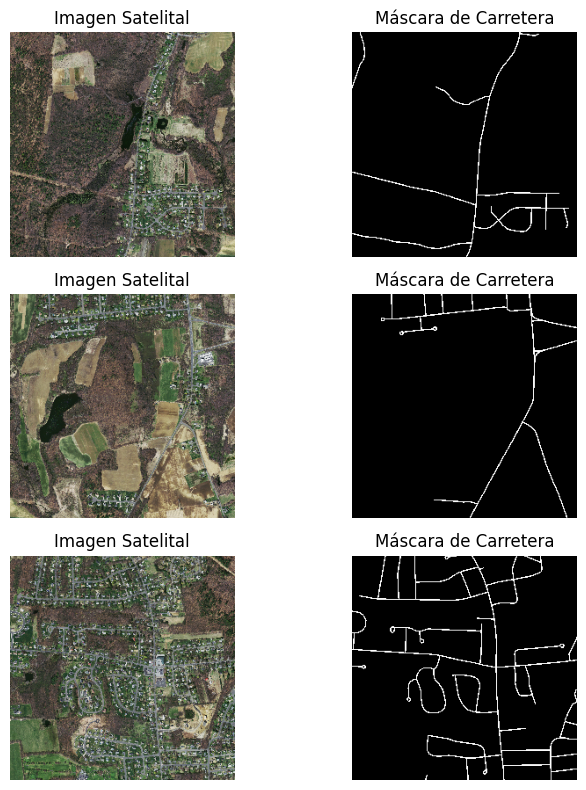

In [72]:
# Mostrar algunas imágenes y sus máscaras correspondientes
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 8))
for i in range(num_samples):
    axes[i, 0].imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Imagen Satelital')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(Y[i], cmap='gray')
    axes[i, 1].set_title('Máscara de Carretera')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()


# EXTRACCION DE CARACTERISTICAS

## Este es el que se cambia para realizar la tabla

In [ ]:
from skimage.feature import local_binary_pattern

def color_extractor(image):
    """
    Extrae características de color de manera optimizada
    """
    # Convertir a HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calcular estadísticas globales
    mean_hsv = np.mean(hsv, axis=(0,1))
    std_hsv = np.std(hsv, axis=(0,1))
    
    # Reshape para tener una característica por píxel
    pixel_features = hsv.reshape(-1, 3)
    
    # Agregar características globales a cada píxel
    global_features = np.tile(np.concatenate([mean_hsv, std_hsv]), (pixel_features.shape[0], 1))
    
    # Combinar características
    features = np.hstack([pixel_features, global_features])
    
    return features

def edge_extractor(image):
    """
    Extrae características de bordes mejoradas
    """
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)
    # Detectores de bordes
    edges_canny = cv2.Canny(gray, 100, 200)
    
    # Gradientes usando Sobel con diferentes kernels
    sobel_x3 = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=1)
    sobel_y3 = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=1)
    sobel_x5 = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=1)
    sobel_y5 = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=1)
    
    # Magnitudes de gradiente
    magnitude3 = np.sqrt(sobel_x3**2 + sobel_y3**2)
    magnitude5 = np.sqrt(sobel_x5**2 + sobel_y5**2)
    
    # Características por píxel
    features = np.column_stack([
        edges_canny.flatten(),
        magnitude3.flatten(),
        magnitude5.flatten(),
        np.arctan2(sobel_y3, sobel_x3).flatten(),  # dirección del gradiente
        np.arctan2(sobel_y5, sobel_x5).flatten()   # dirección del gradiente con kernel mayor
    ])
    
    return features

def gabor_extractor(image):
    """
    Extrae características usando filtros de Gabor con diferentes orientaciones
    """
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)
    
    # Crear kernels de Gabor con diferentes orientaciones
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kernel = cv2.getGaborKernel(
            ksize=(21, 21),
            sigma=8.0,
            theta=theta,
            lambd=10.0,
            gamma=0.5,
            psi=0,
            ktype=cv2.CV_32F
        )
        kernels.append(kernel)
    
    # Aplicar filtros y extraer características
    filtered_outputs = []
    for kernel in kernels:
        filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)
        filtered_outputs.append(filtered.flatten())
    
    # Combinar todas las características
    features = np.column_stack(filtered_outputs)
    
    return features

def enhanced_edge_extractor(image):
    """
    Extrae características avanzadas de bordes combinando múltiples técnicas
    """
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)
    
    # Sobel en diferentes escalas
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Magnitud y dirección del gradiente
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    direction = np.arctan2(sobely, sobelx)
    
    # Laplaciano para detección de bordes adicional
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    
    # Combinar características
    features = np.column_stack([
        magnitude.flatten(),
        direction.flatten(),
        laplacian.flatten()
    ])
    
    return features

def spectral_extractor(image):
    """
    Extrae características espectrales incluyendo NDVI y otros índices
    """
    # Asegurar que la imagen sea float
    img_float = image.astype(float) + 1e-6
    
    # Extraer canales
    b = img_float[:, :, 0]
    g = img_float[:, :, 1]
    r = img_float[:, :, 2]
    
    # Calcular NDVI (usando R como NIR y B como Red)
    ndvi = (r - b) / (r + b)
    
    # Calcular otros índices espectrales
    # Índice de vegetación ajustado al suelo (SAVI)
    L = 0.5
    savi = ((r - b) * (1 + L)) / (r + b + L)
    
    # Índice de vegetación mejorado (EVI)
    evi = 2.5 * ((r - b) / (r + 6 * b - 7.5 * g + 1))
    
    # Combinar características
    features = np.column_stack([
        r.flatten(),
        g.flatten(),
        b.flatten(),
        ndvi.flatten(),
        savi.flatten(),
        evi.flatten()
    ])
    
    return features

def complete_feature_extractor(image):
    """
    Combina todos los extractores de características en uno solo
    """
    # Extraer todas las características
    gabor_features = gabor_extractor(image)
    edge_features = enhanced_edge_extractor(image)
    spectral_features = spectral_extractor(image)
    
    # Combinar todas las características
    features = np.hstack([
        gabor_features,
        edge_features,
        spectral_features
    ])
    
    return features

In [74]:
def carac_labels(extractor, x, y):
    """
    Extrae características y etiquetas de manera organizada por imagen
    
    Parameters:
    -----------
    extractor : función
        Función que extrae características de una imagen
    x : array-like
        Imágenes de entrada
    y : array-like
        Máscaras correspondientes
    """
    features_list = []
    labels_list = []
    
    for img, mask in zip(x, y):
        if extractor is not None:
            # Extraer características para cada imagen
            features = extractor(img)
            
            # Aplanar la máscara correspondiente
            labels = mask.flatten()
            
            # Agregar a las listas
            features_list.append(features)
            labels_list.append(labels)
    
    # Combinar todas las características y etiquetas
    X_features = np.vstack(features_list)
    Y_labels = np.concatenate(labels_list)
    
    print("Formas después de la extracción:")
    print(f"X_features: {X_features.shape}")
    print(f"Y_labels: {Y_labels.shape}")
    
    return X_features, Y_labels

In [75]:
def extract_all_features(X, Y, extractors):
    """
    Extrae características usando múltiples extractores y almacena los resultados
    
    Parameters:
    -----------
    X : array-like
        Imágenes de entrada
    Y : array-like
        Máscaras correspondientes
    extractors : list
        Lista de funciones extractoras de características
        
    Returns:
    --------
    features_dict : dict
        Diccionario con las características extraídas por cada extractor
    labels_dict : dict
        Diccionario con las etiquetas correspondientes
    """
    features_dict = {}
    labels_dict = {}
    
    for extractor in extractors:
        # Obtener el nombre del extractor
        extractor_name = extractor.__name__
        
        print(f"\nProcesando {extractor_name}...")
        try:
            # Extraer características y etiquetas
            X_features, Y_labels = carac_labels(extractor, X, Y)
            
            # Almacenar en diccionarios
            features_dict[extractor_name] = X_features
            labels_dict[extractor_name] = Y_labels
            
            print(f"Forma de características: {X_features.shape}")
            print(f"Forma de etiquetas: {Y_labels.shape}")
            
        except Exception as e:
            print(f"Error en {extractor_name}: {str(e)}")
            continue
    
    return features_dict, labels_dict

# Definir los extractores
extractors = [
    color_extractor,
    edge_extractor,
    gabor_extractor,
    enhanced_edge_extractor,
    spectral_extractor,
    complete_feature_extractor
]

# Extraer todas las características
features_dict, labels_dict = extract_all_features(X, Y, extractors)


Procesando color_extractor...
Formas después de la extracción:
X_features: (1310720, 9)
Y_labels: (1310720,)
Forma de características: (1310720, 9)
Forma de etiquetas: (1310720,)

Procesando edge_extractor...
Formas después de la extracción:
X_features: (1310720, 5)
Y_labels: (1310720,)
Forma de características: (1310720, 5)
Forma de etiquetas: (1310720,)

Procesando gabor_extractor...
Formas después de la extracción:
X_features: (1310720, 4)
Y_labels: (1310720,)
Forma de características: (1310720, 4)
Forma de etiquetas: (1310720,)

Procesando enhanced_edge_extractor...
Formas después de la extracción:
X_features: (1310720, 3)
Y_labels: (1310720,)
Forma de características: (1310720, 3)
Forma de etiquetas: (1310720,)

Procesando spectral_extractor...
Formas después de la extracción:
X_features: (1310720, 6)
Y_labels: (1310720,)
Forma de características: (1310720, 6)
Forma de etiquetas: (1310720,)

Procesando complete_feature_extractor...
Formas después de la extracción:
X_features: (13

# PREPARADO Y BALANCEO

In [76]:
# Ejemplo de cómo usar las características de un extractor específico:
def train_specific_extractor(extractor_name, features_dict, labels_dict):
    """
    Entrena un modelo usando las características de un extractor específico
    """
    if extractor_name not in features_dict:
        print(f"Extractor {extractor_name} no encontrado")
        return None
    
    X_features = features_dict[extractor_name]
    Y_labels = labels_dict[extractor_name]
    
    # Balancear clases
    from sklearn.utils import resample
    
    # Separar por clase
    mask_0 = Y_labels == 0
    mask_1 = Y_labels == 1
    
    X_class0 = X_features[mask_0]
    X_class1 = X_features[mask_1]
    y_class0 = Y_labels[mask_0]
    y_class1 = Y_labels[mask_1]
    
    # Undersampling de la clase mayoritaria
    if len(y_class0) > len(y_class1):
        X_class0, y_class0 = resample(X_class0, y_class0,
                                    n_samples=len(y_class1),
                                    random_state=42)
    else:
        X_class1, y_class1 = resample(X_class1, y_class1,
                                    n_samples=len(y_class0),
                                    random_state=42)
    
    # Combinar datos balanceados
    X_balanced = np.vstack((X_class0, X_class1))
    y_balanced = np.hstack((y_class0, y_class1))
    
    # Entrenar modelo
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# ENTRENAMIENTO

In [77]:
def train_model(X, y, n_splits=5):
    """
    Entrena el modelo con validación cruzada y técnicas adicionales
    """
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
    from xgboost import XGBClassifier
    
    # Configurar validación cruzada
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Parámetros del modelo
    params = {
        'n_estimators': 200,
        'max_depth': 8,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Almacenar resultados
    results = []
    models = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Entrenar modelo
        clf = XGBClassifier(**params)
        clf.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False)
        
        # Predicciones
        y_pred = clf.predict(X_val)
        y_pred_proba = clf.predict_proba(X_val)[:, 1]
        
        # Métricas
        metrics = {
            'fold': fold,
            'accuracy': accuracy_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'auc': roc_auc_score(y_val, y_pred_proba)
        }
        
        results.append(metrics)
        models.append(clf)
    
    '''
    # Calcular promedios
    avg_metrics = {
        metric: np.mean([r[metric] for r in results])
        for metric in ['accuracy', 'recall', 'f1', 'auc']
    }
    
    print("\nPromedios finales:")
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    '''
    
    return models, results

def evaluate_model(model, X_test, y_test):
    """
    Evalúa el modelo y genera visualizaciones
    """
    from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
    import matplotlib.pyplot as plt
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualización
    plt.figure(figsize=(12, 4))

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc(fpr, tpr):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    
    # Imprimir reporte detallado
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    return {
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': auc(fpr, tpr)
    }


# ENTRENAMIENTO Y EVALUACION


Procesando color_extractor

Entrenando modelo con validación cruzada...

Evaluando en conjunto de prueba...

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     11511
         1.0       0.87      0.85      0.86     11400

    accuracy                           0.86     22911
   macro avg       0.86      0.86      0.86     22911
weighted avg       0.86      0.86      0.86     22911


Métricas principales:
------------------------------
Accuracy: 0.8604
Recall: 0.8504
F1-Score: 0.8584
AUC: 0.9231

Matriz de Confusión:
------------------------------
[[10018  1493]
 [ 1705  9695]]

Procesando edge_extractor

Entrenando modelo con validación cruzada...

Evaluando en conjunto de prueba...

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.57      0.58      0.57     11511
         1.0       0.57      0.55      0.56     11400

    accuracy                           

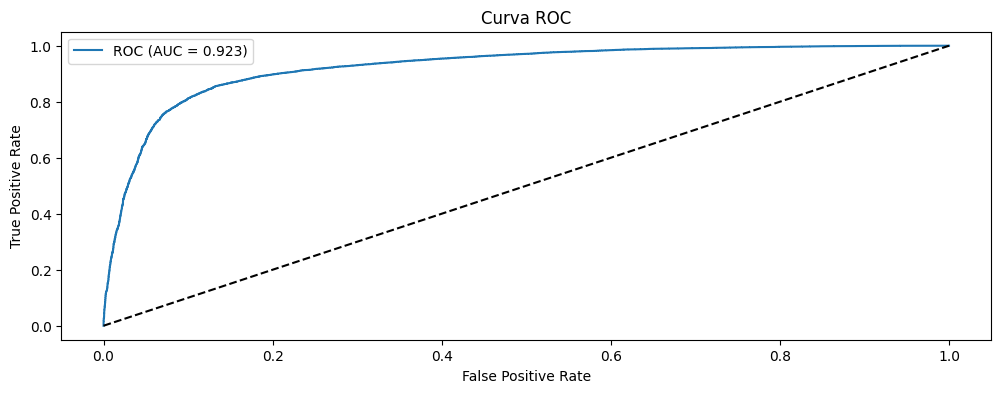

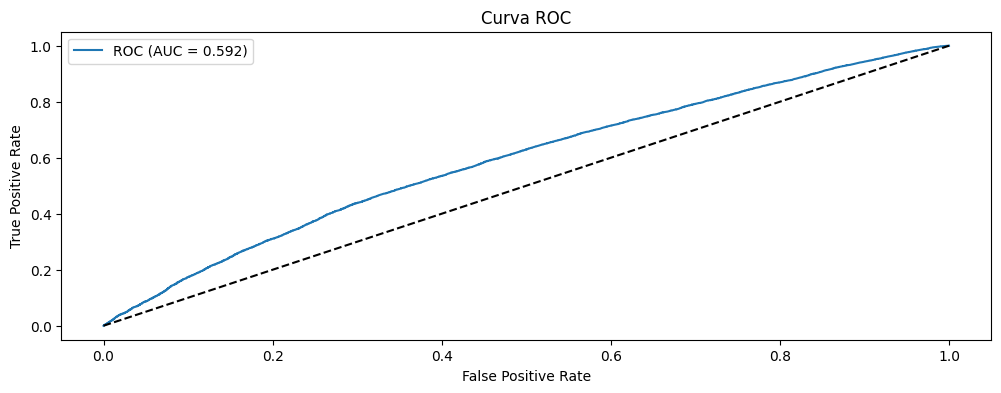

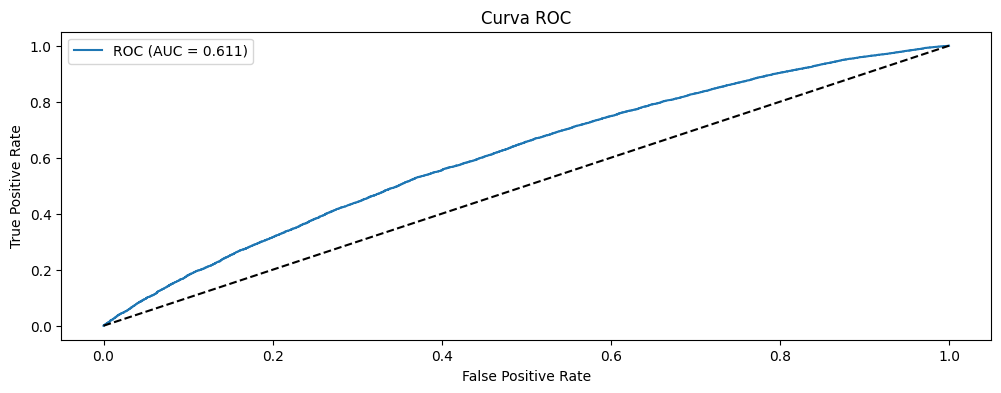

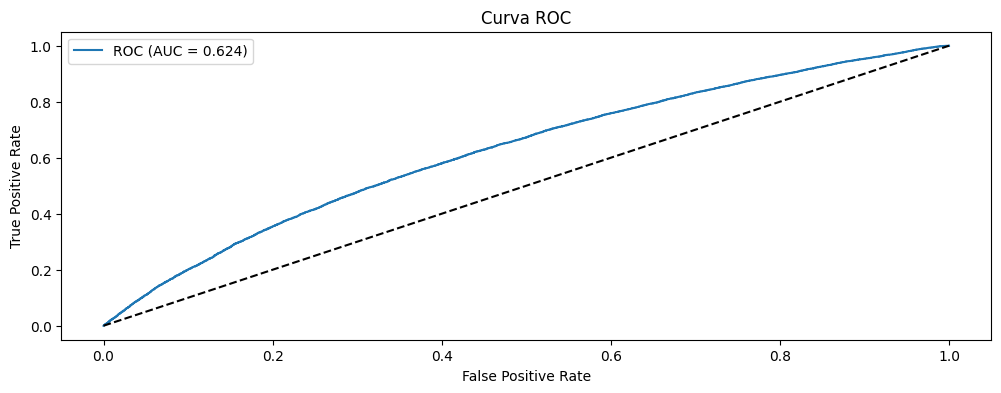

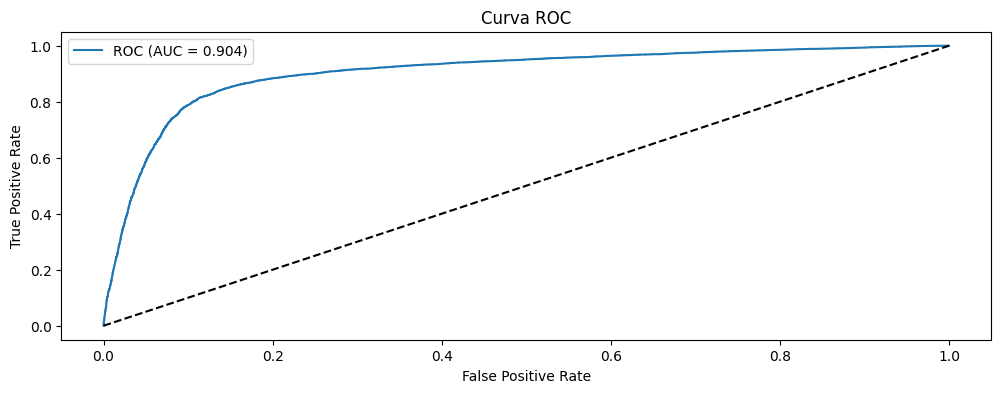

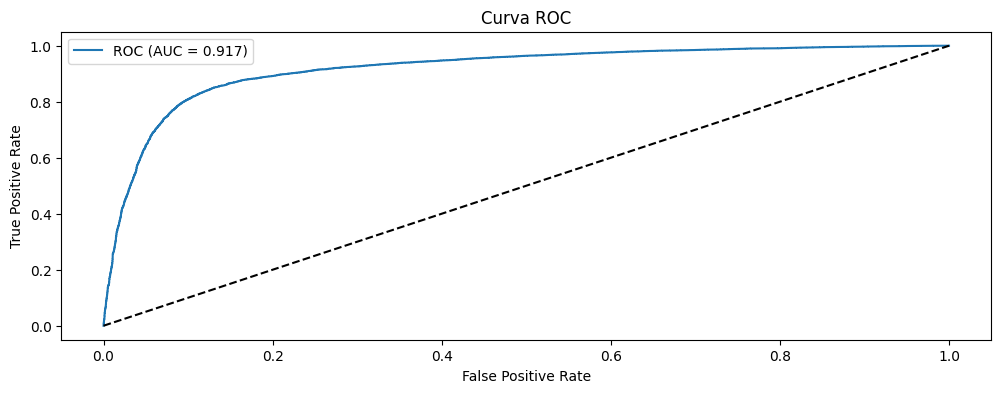

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

def train_and_evaluate_extractor(extractor_name, features_dict, labels_dict):
    """
    Entrena y evalúa un modelo para un extractor específico
    
    Parameters:
    -----------
    extractor_name : str
        Nombre del extractor de características
    features_dict : dict
        Diccionario con las características extraídas
    labels_dict : dict
        Diccionario con las etiquetas correspondientes
    """
    print(f"\n{'='*50}")
    print(f"Procesando {extractor_name}")
    print(f"{'='*50}")
    
    # Preparar datos
    X_train, X_test, y_train, y_test = train_specific_extractor(
        extractor_name, features_dict, labels_dict)
    
    # Entrenar modelo con validación cruzada
    print("\nEntrenando modelo con validación cruzada...")
    models, training_results = train_model(X_train, y_train, n_splits=5)
    
    # Seleccionar mejor modelo
    best_model_idx = np.argmax([result['f1'] for result in training_results])
    best_model = models[best_model_idx]
    
    
    # Evaluar en conjunto de prueba
    print("\nEvaluando en conjunto de prueba...")
    evaluation_results = evaluate_model(
        model=best_model,
        X_test=X_test,
        y_test=y_test
    )
    
    return best_model, evaluation_results

def print_evaluation_summary(evaluation_results, y_test, y_pred, y_pred_proba):
    """
    Imprime un resumen de la evaluación del modelo
    """
    print("\nMétricas principales:")
    print("-" * 30)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    print("\nMatriz de Confusión:")
    print("-" * 30)
    print(evaluation_results['confusion_matrix'])
    
    '''
    print("\nReporte de Clasificación:")
    print("-" * 30)
    print(evaluation_results['classification_report'])
    '''
    return metrics

def evaluate_all_extractors(features_dict, labels_dict):
    """
    Evalúa todos los extractores y compara sus resultados
    """
    results = {}
    
    for extractor_name in features_dict.keys():
        try:
            # Entrenar y evaluar modelo
            best_model, evaluation_results = train_and_evaluate_extractor(
                extractor_name, features_dict, labels_dict)
            
            # Obtener predicciones
            X_train, X_test, y_train, y_test = train_specific_extractor(
                extractor_name, features_dict, labels_dict)
            y_pred = best_model.predict(X_test)
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            
            # Imprimir resultados detallados
            metrics = print_evaluation_summary(
                evaluation_results, y_test, y_pred, y_pred_proba)
            
            # Almacenar resultados
            results[extractor_name] = {
                'model': best_model,
                'metrics': metrics,
                'evaluation': evaluation_results
            }
            
        except Exception as e:
            print(f"\nError procesando {extractor_name}: {str(e)}")
            continue
    
    return results

base_classifier = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# APLICACIONES DEL BASELINE
base_x, base_y = carac_labels(None, X, Y)
baseline = train_and_evaluate_extractor(None, base_x, base_y)

# Evaluar todos los extractores
results = evaluate_all_extractors(features_dict, labels_dict)

# Imprimir tabla comparativa
print("\nComparación de extractores:")
print("=" * 80)
metrics_names = ['Accuracy', 'Recall', 'F1-Score', 'AUC']

# Crear tabla de resultados
headers = ['Extractor'] + metrics_names
table_data = []

for extractor_name, result in results.items():
    row = [extractor_name]
    metrics = result['metrics']
    row.extend([metrics[metric] for metric in metrics_names])
    table_data.append(row)


# COMPROBAR NUEVAS IMAGENES

In [79]:
# Preprocesamiento de la imagen
def preprocess_image(img_path, img_size=(256, 256)):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, img_size)
    img_resized = img_resized.astype('float32') / 255.0
    return img_resized

# Postprocesamiento de la máscara
def postprocess_mask(mask, img_size):
    mask = mask.reshape(img_size)
    mask = (mask > 0.5).astype(np.uint8)
    return mask



Procesando predicciones con color_extractor

Estadísticas para imagen 1:
Min: 0.000
Max: 1.000
Media: 0.164

Estadísticas para imagen 2:
Min: 0.000
Max: 1.000
Media: 0.177

Procesando predicciones con edge_extractor

Estadísticas para imagen 1:
Min: 0.000
Max: 1.000
Media: 0.446

Estadísticas para imagen 2:
Min: 0.000
Max: 1.000
Media: 0.402

Procesando predicciones con gabor_extractor

Estadísticas para imagen 1:
Min: 0.000
Max: 1.000
Media: 0.430

Estadísticas para imagen 2:
Min: 0.000
Max: 1.000
Media: 0.386

Procesando predicciones con enhanced_edge_extractor

Estadísticas para imagen 1:
Min: 0.000
Max: 1.000
Media: 0.440

Estadísticas para imagen 2:
Min: 0.000
Max: 1.000
Media: 0.407

Procesando predicciones con spectral_extractor

Estadísticas para imagen 1:
Min: 0.000
Max: 1.000
Media: 0.194

Estadísticas para imagen 2:
Min: 0.000
Max: 1.000
Media: 0.149

Procesando predicciones con complete_feature_extractor

Estadísticas para imagen 1:
Min: 0.000
Max: 1.000
Media: 0.186

Esta

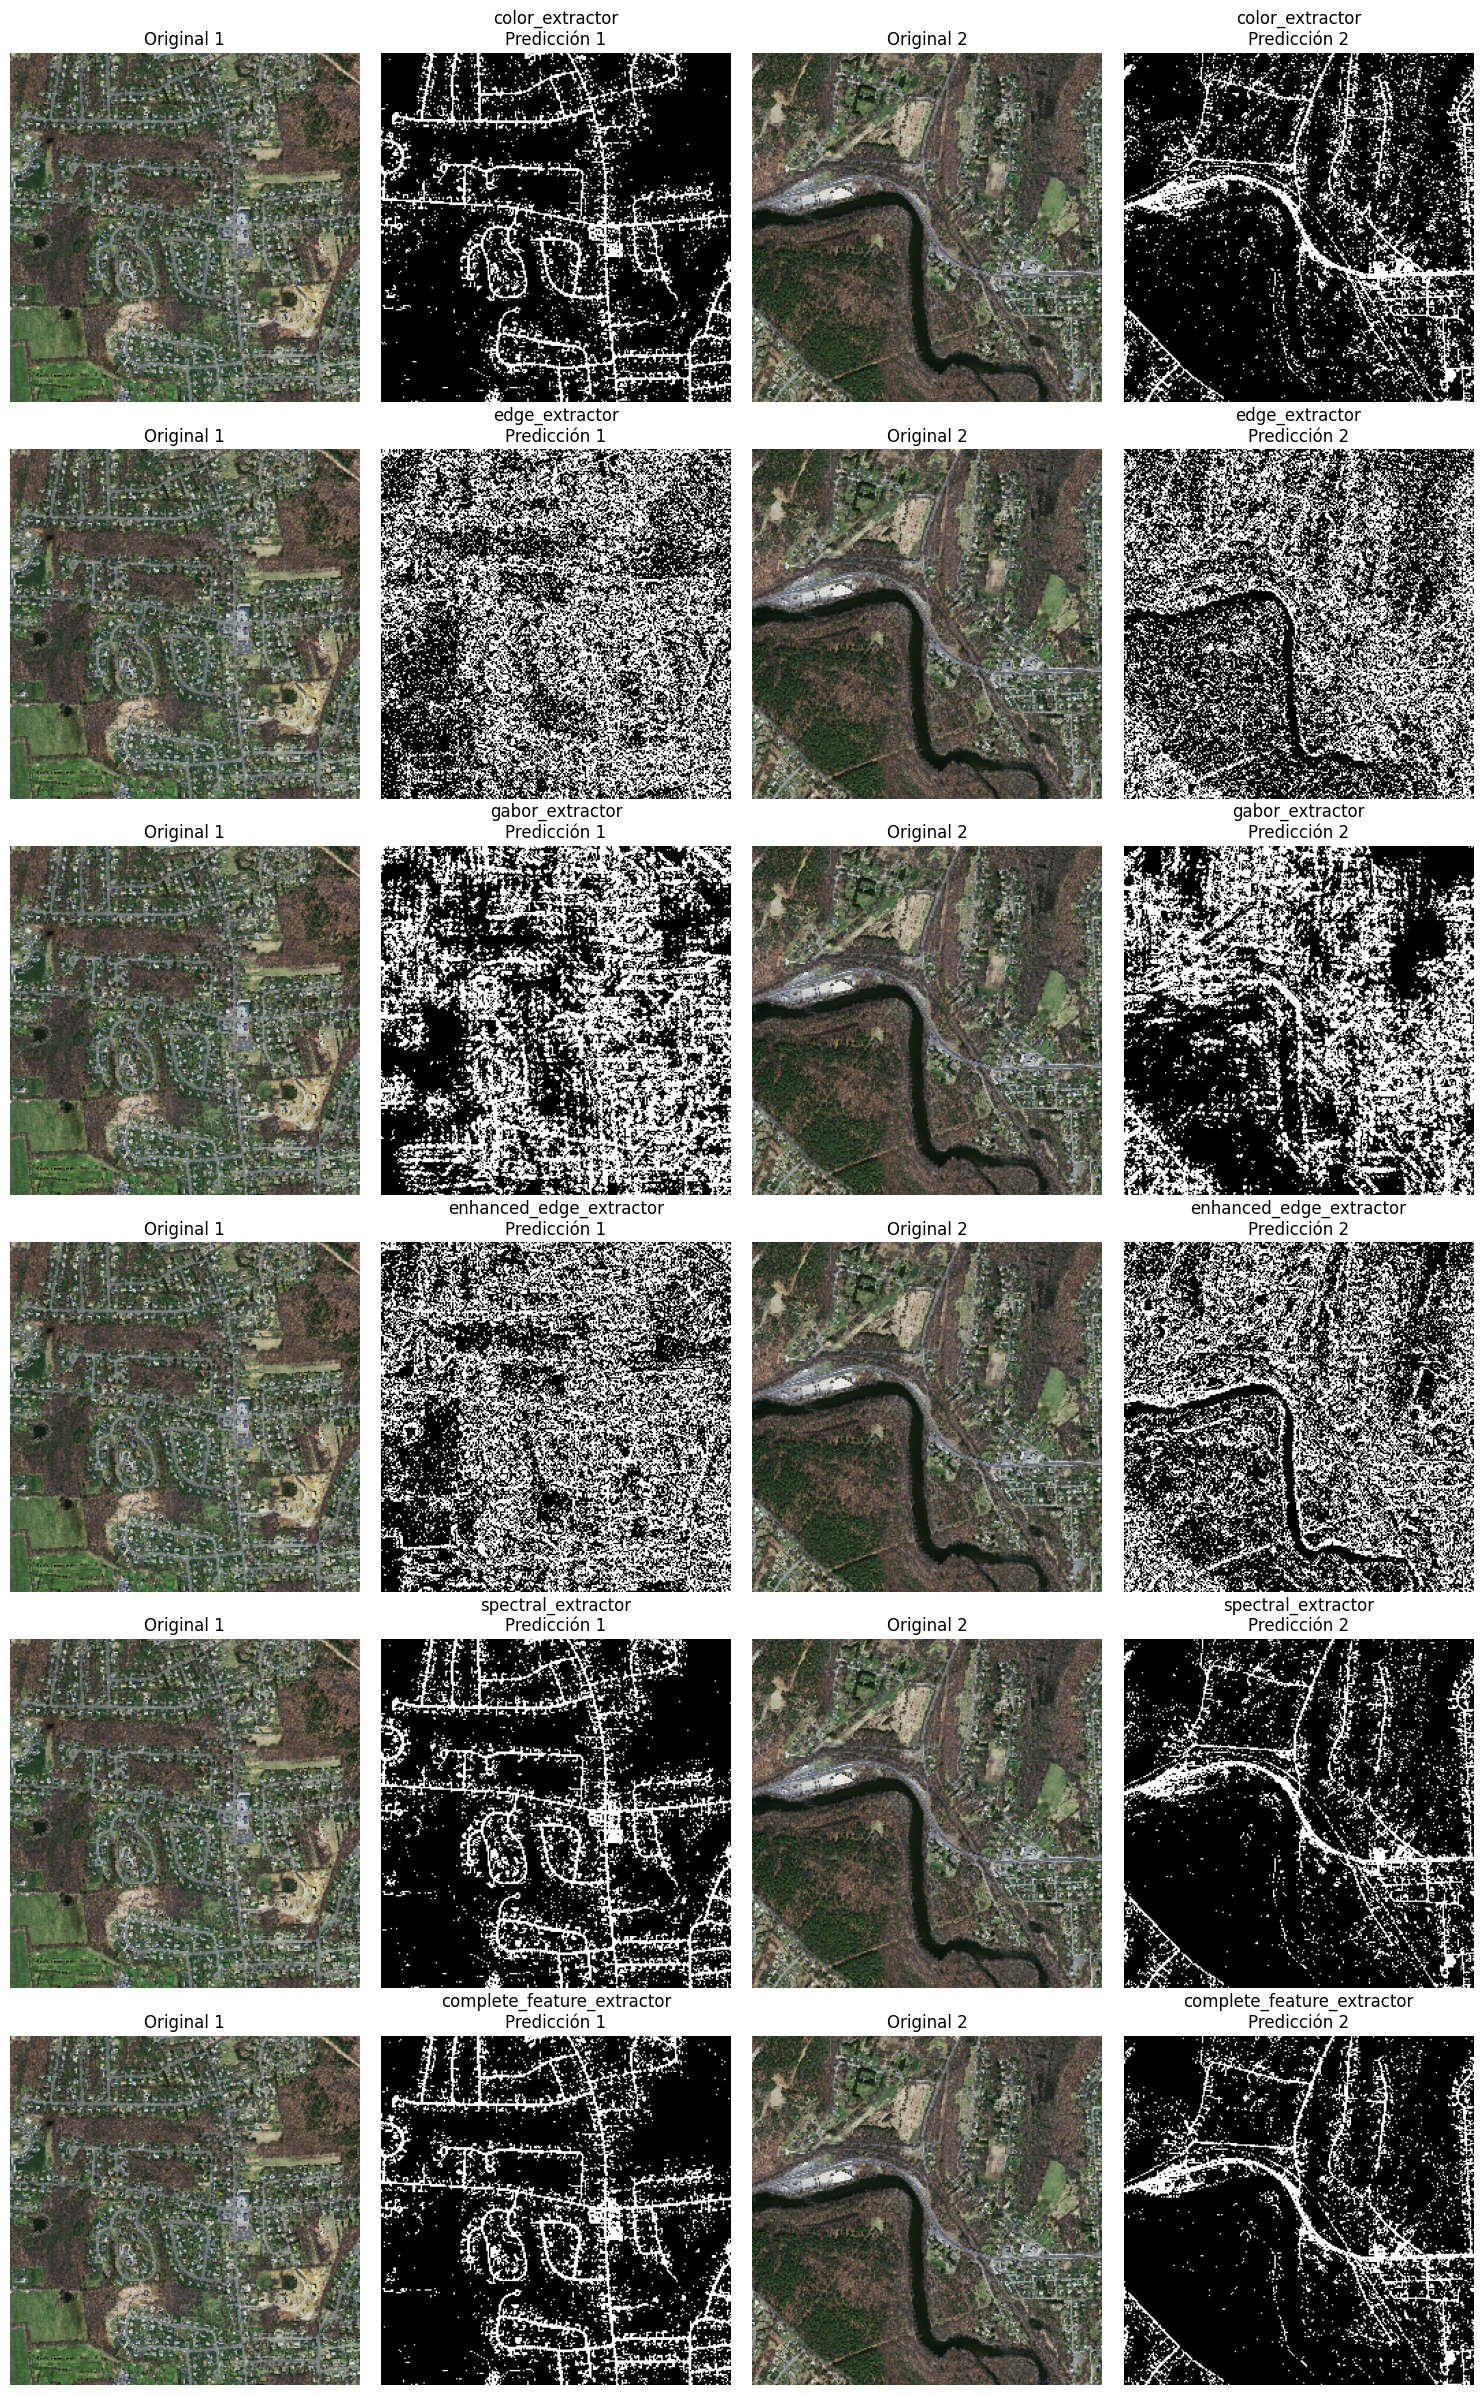

In [80]:
def predict_image(image, extractor, clf):
    """
    Predice la máscara para toda la imagen
    """
    height, width = image.shape[:2]
    
    # Extraer características para cada píxel
    features = extractor(image)
    
    # Predecir para cada píxel
    predictions = clf.predict(features)
    
    # Reorganizar en forma de máscara
    mask = predictions.reshape(height, width)
    
    return mask


def predict_and_visualize_all(image_paths, results_dict, img_size=(256, 256)):
    """
    Predice y visualiza resultados usando todos los modelos entrenados
    
    Parameters:
    -----------
    image_paths : list
        Lista de rutas de imágenes a procesar
    results_dict : dict
        Diccionario con los resultados del entrenamiento por extractor
    img_size : tuple
        Tamaño de imagen deseado
    """
    # Preprocesar imágenes
    processed_images = []
    for img_path in image_paths:
        try:
            img = preprocess_image(img_path, img_size)
            processed_images.append(img)
        except Exception as e:
            print(f"Error procesando {img_path}: {str(e)}")
            return
    
    # Crear figura para visualización
    n_extractors = len(results_dict)
    n_images = len(processed_images)
    fig_height = 4 * n_extractors
    fig_width = 15
    
    fig, axes = plt.subplots(n_extractors, n_images * 2, 
                            figsize=(fig_width, fig_height))
    
    # Para cada extractor
    for idx, (extractor_name, results) in enumerate(results_dict.items()):
        print(f"\nProcesando predicciones con {extractor_name}")
        
        model = results['model']
        extractor = globals()[extractor_name]  # Obtener la función extractora
        
        # Para cada imagen
        for img_idx, img in enumerate(processed_images):
            try:
                # Predecir máscara
                mask_pred = predict_image(img, extractor, model)
                
                # Postprocesar máscara
                mask_cleaned = postprocess_mask(mask_pred, img_size=img_size)
                
                # Visualizar resultados
                if n_extractors > 1:
                    ax_img = axes[idx, img_idx*2]
                    ax_mask = axes[idx, img_idx*2 + 1]
                else:
                    ax_img = axes[img_idx*2]
                    ax_mask = axes[img_idx*2 + 1]
                
                # Mostrar imagen original
                ax_img.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax_img.set_title(f'Original {img_idx+1}')
                ax_img.axis('off')
                
                # Mostrar máscara predicha
                mask_plot = ax_mask.imshow(mask_cleaned, cmap='gray')
                ax_mask.set_title(f'{extractor_name}\nPredicción {img_idx+1}')
                ax_mask.axis('off')
                
                # Imprimir estadísticas
                print(f"\nEstadísticas para imagen {img_idx+1}:")
                print(f"Min: {mask_cleaned.min():.3f}")
                print(f"Max: {mask_cleaned.max():.3f}")
                print(f"Media: {mask_cleaned.mean():.3f}")
                
            except Exception as e:
                print(f"Error en predicción: {str(e)}")
                continue
    
    plt.tight_layout()
    plt.show()


# Lista de imágenes a procesar
image_paths = [
    "roads/sat/10228705_15.tiff",
    "roads/sat/10228735_15.tiff"
]

# Visualizar predicciones
predict_and_visualize_all(image_paths, results)